In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.metrics import accuracy_score


class MACPredictorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(MACPredictorLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers,
            batch_first=True,
            dropout=dropout_rate, 
            bidirectional=False
        )
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        
        out = self.fc(out)
        
        return out

def load_data(file_path):
    df = pd.read_json(file_path, lines=True)
    df = df.drop(columns=['d_mac'])
    df = df.fillna(0.0)
    return df

def encode_target(df, le=None, is_train=True):
    # Initialize LabelEncoder for training, or use existing one for testing
    if is_train:
        le = LabelEncoder()
        df['s_mac_encoded'] = le.fit_transform(df['s_mac'])
        num_classes = len(le.classes_)
        return df.drop(columns=['s_mac']), num_classes, le
    else:
        # handle case where mac address seen in test but not in case
        from collections import Counter
        print("Source mac address counts: ")
        print(Counter(df['s_mac'])['14:cc:20:51:33:ea'])
        df['s_mac_encoded'] = le.transform(df['s_mac'])
        return df.drop(columns=['s_mac']), None, le

def scale_features(df, scaler=None, is_train=True):
    # Identify numerical features (all columns except the encoded target)
    feature_cols = [col for col in df.columns if col != 's_mac_encoded']
    
    if is_train:
        scaler = MinMaxScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
        return df, scaler, feature_cols
    else:
        # Use existing scaler, only transform.
        df[feature_cols] = scaler.transform(df[feature_cols])
        return df, scaler, feature_cols

def create_sequences(df, look_back):
    feature_cols = [col for col in df.columns if col != 's_mac_encoded']
    data = df[feature_cols].values
    target = df['s_mac_encoded'].values
    
    X, Y = [], []
    for i in range(look_back, len(df)):
        X.append(data[i - look_back:i, :])
        Y.append(target[i])

    return np.array(X), np.array(Y)

class MACDataset(Dataset):
    #convert to tensors
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long() 
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    """Trains the LSTM model."""
    model.train()
    print(f"\n--- Starting Training on {device} for {num_epochs} epochs ---")
    start_time = time.time()

    train_loss = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (sequences, labels) in enumerate(train_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        train_loss[epoch] = avg_loss
        #print(train_loss)

    end_time = time.time()
    print(f"Training Complete. Total time: {(end_time - start_time):.2f}s")
    return train_loss

In [ ]:
def evaluate_model(model, test_loader, device, label_encoder):
    model.eval()
    print("\n--- Starting Evaluation ---")
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    
    try:
        sample_true_mac = label_encoder.inverse_transform(y_true)
        sample_pred_mac = label_encoder.inverse_transform(y_pred)
    except ValueError:
        sample_true_mac = [f"Encoded: {i}" for i in y_true]
        sample_pred_mac = [f"Encoded: {i}" for i in y_pred]


    print(f"Classification Accuracy: {accuracy*100:.2f}%")
    print("\nSample Predictions:")
    print(pd.DataFrame({'True MAC': sample_true_mac, 'Predicted MAC': sample_pred_mac}))
    return sample_true_mac, sample_pred_mac

In [ ]:
TRAIN_FILE = 'all_features_with_mac_part1_80.jsonl'
TEST_FILE = 'all_features_with_mac_part2_20.jsonl'

LOOK_BACK = 30 
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 60
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT_RATE = 0.20

# Use GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
print(f"Using device: {device}")

df_train = load_data(TRAIN_FILE)
df_test = load_data(TEST_FILE)

df_train, num_classes, le = encode_target(df_train, is_train=True)
df_test, _, _ = encode_target(df_test, le=le, is_train=False)

df_train, scaler, feature_cols = scale_features(df_train, is_train=True)
df_test, _, _ = scale_features(df_test, scaler=scaler, is_train=False)
input_size = len(feature_cols)

X_train, Y_train = create_sequences(df_train, look_back=LOOK_BACK)
X_test, Y_test = create_sequences(df_test, look_back=LOOK_BACK)

if X_train.size == 0 or X_test.size == 0:
    print(f"ERROR: Not enough data points ({len(df_train)} train, {len(df_test)} test) for a look_back of {LOOK_BACK}.")
    print("Please check your input files or reduce the LOOK_BACK value.")

print(f"Sequence created. X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"Input Features: {input_size}, Total Classes: {num_classes}")

train_dataset = MACDataset(X_train, Y_train)
test_dataset = MACDataset(X_test, Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = MACPredictorLSTM(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE
).to(device)


criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using device: mps
Source mac address counts: 
22
Sequence created. X_train shape: (203995, 30, 17), Y_train shape: (203995,)
Input Features: 17, Total Classes: 32


In [5]:
# 7. Train Model
train_loss = train_model(model, train_loader, criterion, optimizer, device, NUM_EPOCHS)


--- Starting Training on mps for 60 epochs ---
Epoch [1/60], Loss: 1.1975
Epoch [2/60], Loss: 0.8364
Epoch [3/60], Loss: 0.7537
Epoch [4/60], Loss: 0.7179
Epoch [5/60], Loss: 0.6940
Epoch [6/60], Loss: 0.6760
Epoch [7/60], Loss: 0.6626
Epoch [8/60], Loss: 0.6515
Epoch [9/60], Loss: 0.6440
Epoch [10/60], Loss: 0.6369
Epoch [11/60], Loss: 0.6293
Epoch [12/60], Loss: 0.6241
Epoch [13/60], Loss: 0.6179
Epoch [14/60], Loss: 0.6130
Epoch [15/60], Loss: 0.6083
Epoch [16/60], Loss: 0.6036
Epoch [17/60], Loss: 0.5999
Epoch [18/60], Loss: 0.5960
Epoch [19/60], Loss: 0.5933
Epoch [20/60], Loss: 0.5911
Epoch [21/60], Loss: 0.5872
Epoch [22/60], Loss: 0.5850
Epoch [23/60], Loss: 0.5817
Epoch [24/60], Loss: 0.5797
Epoch [25/60], Loss: 0.5781
Epoch [26/60], Loss: 0.5771
Epoch [27/60], Loss: 0.5770
Epoch [28/60], Loss: 0.5728
Epoch [29/60], Loss: 0.5714
Epoch [30/60], Loss: 0.5711
Epoch [31/60], Loss: 0.5681
Epoch [32/60], Loss: 0.5677
Epoch [33/60], Loss: 0.5654
Epoch [34/60], Loss: 0.5671
Epoch [35

In [15]:
print(train_loss[-10:])

[0.56042233 0.55989949 0.56186424 0.55949594 0.55960711 0.56082504
 0.55875391 0.56390944 0.55876624 0.56032397]


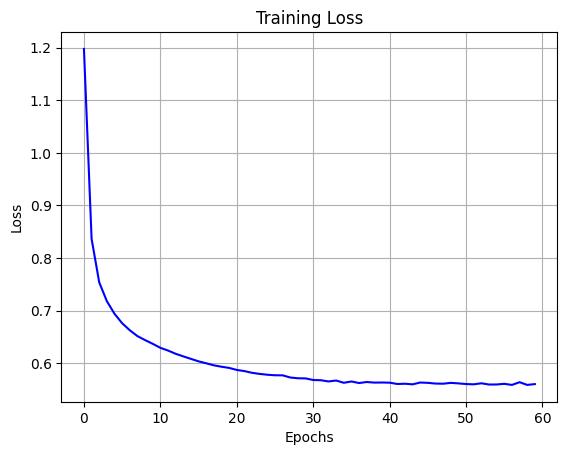

In [16]:
import matplotlib.pyplot as plt
#print(train_loss)
plt.plot(train_loss,color="b")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

In [17]:
# 8. Evaluate Model
true, pred = evaluate_model(model, test_loader, device, le)


--- Starting Evaluation ---
Classification Accuracy: 73.91%

Sample Predictions:
['08:21:ef:3b:fc:e3' '08:21:ef:3b:fc:e3' '08:21:ef:3b:fc:e3' ...
 '74:2f:68:81:69:42' '74:2f:68:81:69:42' '74:2f:68:81:69:42']
@@@@@@@@@@@@@
['b4:ce:f6:a7:a3:c2' 'b4:ce:f6:a7:a3:c2' 'b4:ce:f6:a7:a3:c2' ...
 'ec:1a:59:83:28:11' '74:2f:68:81:69:42' '74:2f:68:81:69:42']
@@@@@@@@@@@@@
                True MAC      Predicted MAC
0      08:21:ef:3b:fc:e3  b4:ce:f6:a7:a3:c2
1      08:21:ef:3b:fc:e3  b4:ce:f6:a7:a3:c2
2      08:21:ef:3b:fc:e3  b4:ce:f6:a7:a3:c2
3      08:21:ef:3b:fc:e3  b4:ce:f6:a7:a3:c2
4      08:21:ef:3b:fc:e3  b4:ce:f6:a7:a3:c2
...                  ...                ...
50971  74:2f:68:81:69:42  ec:1a:59:83:28:11
50972  74:2f:68:81:69:42  ec:1a:59:83:28:11
50973  74:2f:68:81:69:42  ec:1a:59:83:28:11
50974  74:2f:68:81:69:42  74:2f:68:81:69:42
50975  74:2f:68:81:69:42  74:2f:68:81:69:42

[50976 rows x 2 columns]


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
true
#cf = confusion_matrix(true,pred)
#type(confusion_matrix)

array(['08:21:ef:3b:fc:e3', '08:21:ef:3b:fc:e3', '08:21:ef:3b:fc:e3', ...,
       '74:2f:68:81:69:42', '74:2f:68:81:69:42', '74:2f:68:81:69:42'],
      dtype=object)

In [11]:
pred

array(['b4:ce:f6:a7:a3:c2', 'b4:ce:f6:a7:a3:c2', 'b4:ce:f6:a7:a3:c2', ...,
       'ec:1a:59:83:28:11', '74:2f:68:81:69:42', '74:2f:68:81:69:42'],
      dtype=object)

In [12]:
len(np.unique(true))

25

In [18]:
from sklearn.metrics import f1_score

# Macro average (unweighted mean of F1 for each class)
f1_macro = f1_score(true, pred, average='macro')

# Weighted average (weighted by support/frequency of each class)
f1_weighted = f1_score(true, pred, average='weighted')

# Micro average (global calculation)
f1_micro = f1_score(true, pred, average='micro')

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")

F1 Score (macro): 0.2020
F1 Score (weighted): 0.7261
F1 Score (micro): 0.7391


25   21


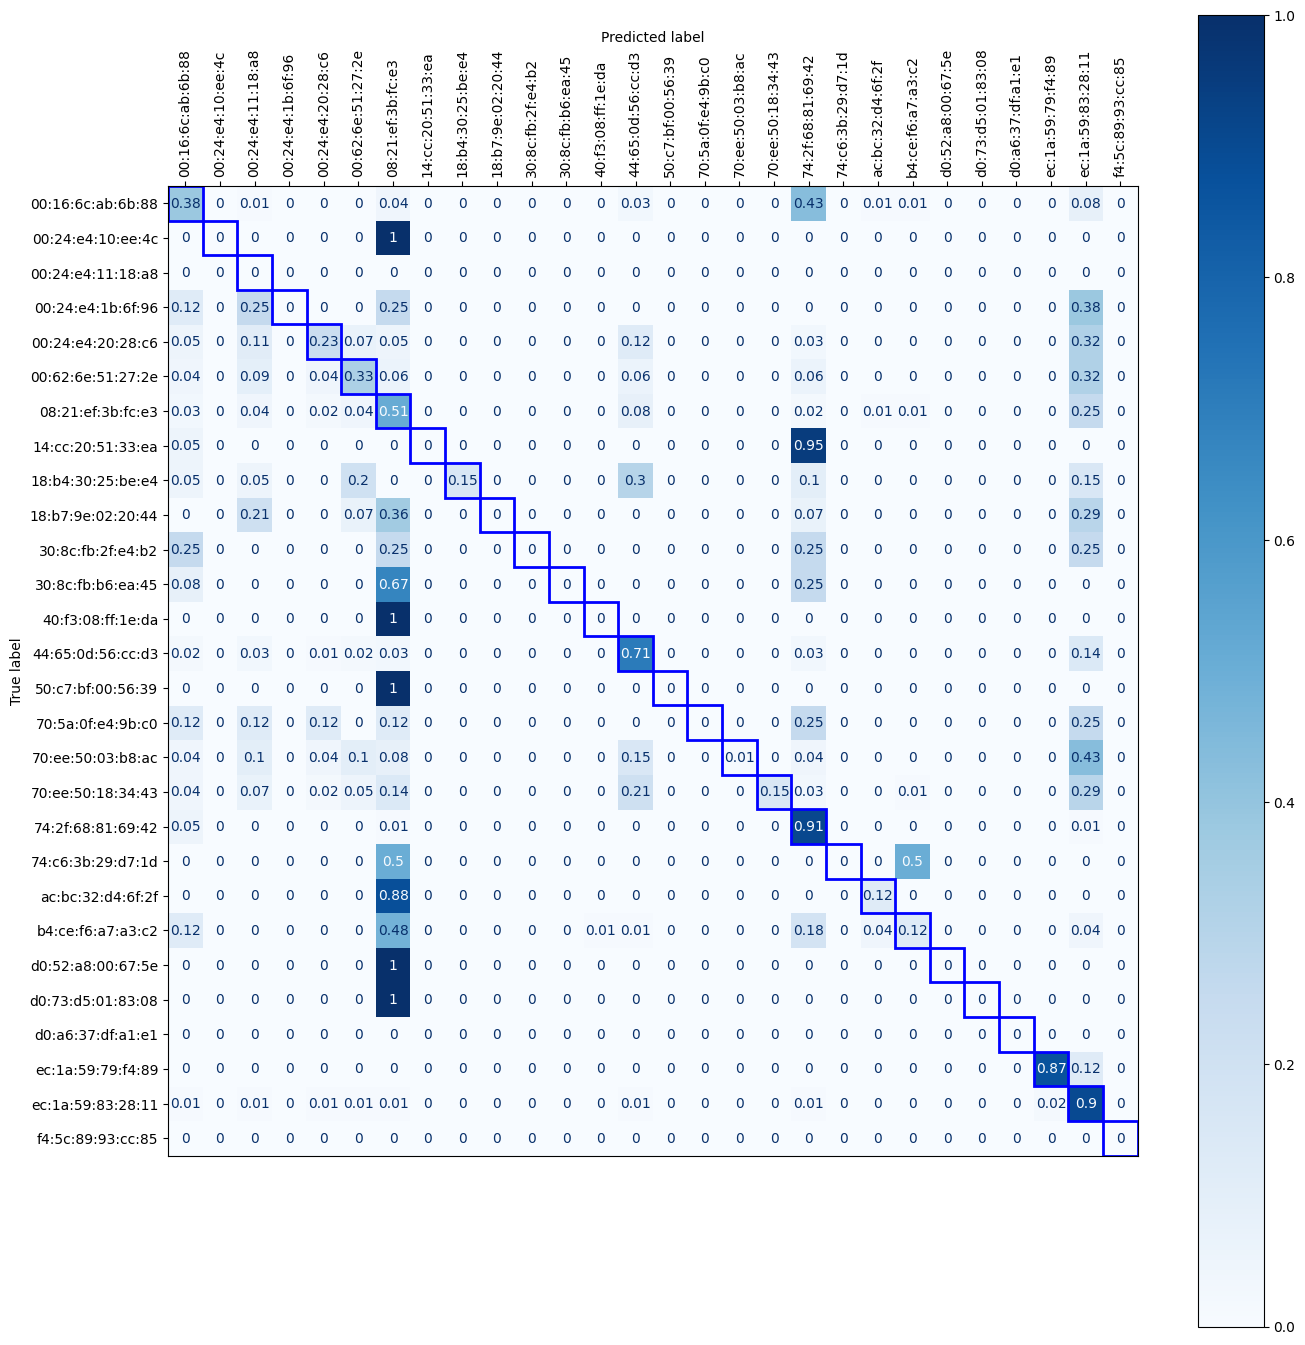

In [14]:
mapping = {}
'''with open("List_Of_Devices.txt",'r') as reader:
    next(reader)
    next(reader)
    for line in reader:
        elements = line.split()
        name, address = " ".join(elements[:-2]), elements[-2]
        #print(name, " ",address)
        mapping[address] = name

print(mapping)'''


labels = sorted(set(true)|set(pred))  # Union of all labels, sorted
print(len(set(true)), " ", len(set(pred)))
cf = confusion_matrix(true,pred,labels=labels,normalize='true')
cf_normalized = np.around(cf,decimals=2)
#cf_normalized= np.around(cf.astype('float') / cf.sum(axis=1)[:, np.newaxis], decimals=2) #normal normalized doesn't round, and .2f doesn't do it that way
#labels = set(pred)
#print(len(labels), " ", len(true))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_normalized,display_labels=labels)

fig, ax = plt.subplots(figsize=(14, 14))
ax.tick_params(
    axis='x',         # Apply to the X-axis
    top=True,         # Show ticks at the top
    labeltop=True,    # Show labels at the top
    bottom=False,     # Hide ticks at the bottom
    labelbottom=False # Hide labels at the bottom
)
ax.xaxis.set_label_position('top')
cm_display.plot(ax=ax, xticks_rotation=90, cmap="Blues")
#box diagonals for better viewing
for i in range(len(labels)):
    ax.add_patch(plt.Rectangle((i-0.5,i-0.5),1,1,fill=False,edgecolor='blue',linewidth=2))
plt.tight_layout()
plt.show()